## Install Dependencies

In [1]:
!pip install albumentations --quiet
!pip install torchsummary --quiet
!pip install tqdm --quiet
!pip install matplotlib --quiet

## Import Modules

In [2]:
# Import all the required modules
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Dataset Analysis

## Extract and Load the Data

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


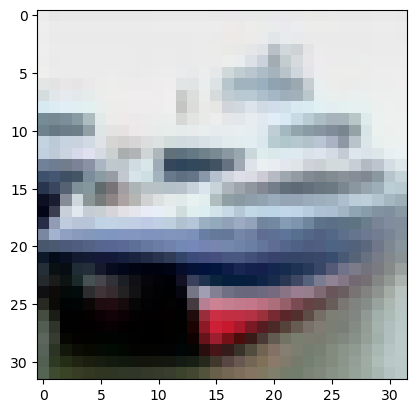

In [4]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Parameters

In [5]:
BATCH_SIZE = 1024
EPOCHS = 100
DISPLAY_SAMPLES = 20
LEARNING_RATE = 0.112
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1
STEPS_PER_EPOCH = math.ceil(50_000/BATCH_SIZE)

## Visualize Training Data

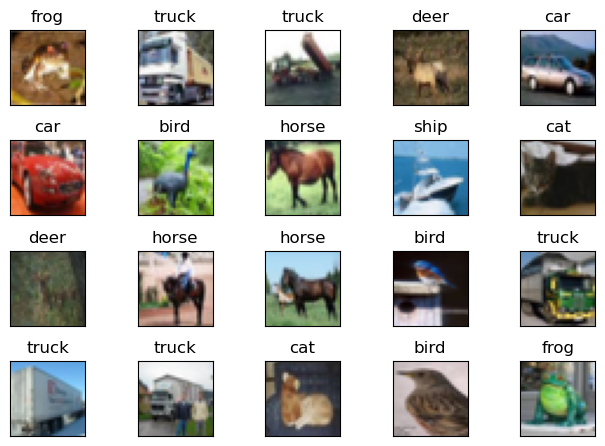

In [6]:
from visualize import display_cifar_data_samples

sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

## Transformations

In [7]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=0.2),
    'horizontalflip': A.HorizontalFlip(),
    'rotation': A.Rotate(15),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

/tmp/ipykernel_4515/1626779572.py:8: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),
/tmp/ipykernel_4515/1626779572.py:8: UserWarning: Argument 'mask_fill_value' is not valid and will be ignored.
  'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),


In [8]:
from datasets import AlbumDataset

train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


/tmp/ipykernel_4515/456349469.py:11: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None, p=1),
/tmp/ipykernel_4515/456349469.py:11: UserWarning: Argument 'mask_fill_value' is not valid and will be ignored.
  'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None, p=1),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8622141..2.0301545].


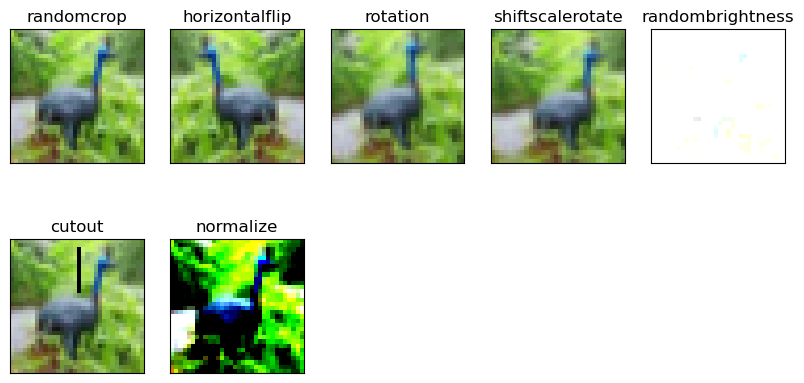

In [9]:
from visualize import visualize_cifar_augmentation

aug_train = AlbumDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'rotation': A.Rotate(15, p=1),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [10]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [11]:
from model import Net
from utils import get_summary

get_summary(Net(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 32, 32, 32]              96
              ReLU-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
              ReLU-7           [-1, 32, 32, 32]               0
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           Dropout-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,216
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
          Dropout-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

## Model Training and Testing

In [12]:
from training_utils import train, test

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


# Put the model on selected device
model = Net().to(device)

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# New Line
criterion = F.nll_loss

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


  0%|          | 0/49 [00:00<?, ?it/s]

Train: Loss=2.0505 Batch_id=48 Accuracy=15.43: 100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


Test set: Average loss: 2.0322, Accuracy: 2118/10000 (21.18%)

Epoch 2


Train: Loss=1.8924 Batch_id=48 Accuracy=24.20: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


Test set: Average loss: 1.8020, Accuracy: 3131/10000 (31.31%)

Epoch 3


Train: Loss=1.7724 Batch_id=48 Accuracy=31.30: 100%|██████████| 49/49 [00:12<00:00,  3.77it/s]


Test set: Average loss: 1.6542, Accuracy: 3804/10000 (38.04%)

Epoch 4


Train: Loss=1.7066 Batch_id=48 Accuracy=35.40: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 1.5706, Accuracy: 4199/10000 (41.99%)

Epoch 5


Train: Loss=1.6040 Batch_id=48 Accuracy=38.71: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 1.4779, Accuracy: 4482/10000 (44.82%)

Epoch 6


Train: Loss=1.5520 Batch_id=48 Accuracy=41.46: 100%|██████████| 49/49 [00:12<00:00,  3.79it/s]


Test set: Average loss: 1.4372, Accuracy: 4764/10000 (47.64%)

Epoch 7


Train: Loss=1.5297 Batch_id=48 Accuracy=43.80: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Test set: Average loss: 1.3647, Accuracy: 5050/10000 (50.50%)

Epoch 8


Train: Loss=1.4683 Batch_id=48 Accuracy=46.38: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Test set: Average loss: 1.3136, Accuracy: 5283/10000 (52.83%)

Epoch 9


Train: Loss=1.3724 Batch_id=48 Accuracy=48.83: 100%|██████████| 49/49 [00:12<00:00,  4.03it/s]


Test set: Average loss: 1.2042, Accuracy: 5674/10000 (56.74%)

Epoch 10


Train: Loss=1.2447 Batch_id=48 Accuracy=51.50: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]


Test set: Average loss: 1.1695, Accuracy: 5848/10000 (58.48%)

Epoch 11


Train: Loss=1.2441 Batch_id=48 Accuracy=53.48: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


Test set: Average loss: 1.1692, Accuracy: 5824/10000 (58.24%)

Epoch 12


Train: Loss=1.1996 Batch_id=48 Accuracy=54.71: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Test set: Average loss: 1.0568, Accuracy: 6251/10000 (62.51%)

Epoch 13


Train: Loss=1.2931 Batch_id=48 Accuracy=56.96: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 1.0060, Accuracy: 6518/10000 (65.18%)

Epoch 14


Train: Loss=1.1893 Batch_id=48 Accuracy=58.53: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]


Test set: Average loss: 0.9195, Accuracy: 6707/10000 (67.07%)

Epoch 15


Train: Loss=1.1002 Batch_id=48 Accuracy=58.12: 100%|██████████| 49/49 [00:12<00:00,  3.89it/s]


Test set: Average loss: 0.9816, Accuracy: 6576/10000 (65.76%)

Epoch 16


Train: Loss=1.0966 Batch_id=48 Accuracy=60.60: 100%|██████████| 49/49 [00:12<00:00,  4.01it/s]


Test set: Average loss: 0.9028, Accuracy: 6864/10000 (68.64%)

Epoch 17


Train: Loss=1.0038 Batch_id=48 Accuracy=61.90: 100%|██████████| 49/49 [00:12<00:00,  3.85it/s]


Test set: Average loss: 0.8488, Accuracy: 6960/10000 (69.60%)

Epoch 18


Train: Loss=1.0183 Batch_id=48 Accuracy=63.31: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


Test set: Average loss: 0.8219, Accuracy: 7115/10000 (71.15%)

Epoch 19


Train: Loss=1.0855 Batch_id=48 Accuracy=63.97: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Test set: Average loss: 0.7882, Accuracy: 7251/10000 (72.51%)

Epoch 20


Train: Loss=0.9789 Batch_id=48 Accuracy=65.09: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Test set: Average loss: 0.8056, Accuracy: 7194/10000 (71.94%)

Epoch 21


Train: Loss=0.9853 Batch_id=48 Accuracy=65.51: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]


Test set: Average loss: 0.8430, Accuracy: 7150/10000 (71.50%)

Epoch 22


Train: Loss=0.9279 Batch_id=48 Accuracy=66.63: 100%|██████████| 49/49 [00:12<00:00,  3.93it/s]


Test set: Average loss: 0.7539, Accuracy: 7343/10000 (73.43%)

Epoch 23


Train: Loss=0.9009 Batch_id=48 Accuracy=67.66: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.7207, Accuracy: 7488/10000 (74.88%)

Epoch 24


Train: Loss=0.8725 Batch_id=48 Accuracy=68.30: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Test set: Average loss: 0.7019, Accuracy: 7574/10000 (75.74%)

Epoch 25


Train: Loss=0.9083 Batch_id=48 Accuracy=68.72: 100%|██████████| 49/49 [00:12<00:00,  3.99it/s]


Test set: Average loss: 0.7031, Accuracy: 7575/10000 (75.75%)

Epoch 26


Train: Loss=0.8314 Batch_id=48 Accuracy=69.09: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]


Test set: Average loss: 0.6843, Accuracy: 7613/10000 (76.13%)

Epoch 27


Train: Loss=0.8242 Batch_id=48 Accuracy=69.98: 100%|██████████| 49/49 [00:11<00:00,  4.11it/s]


Test set: Average loss: 0.6454, Accuracy: 7782/10000 (77.82%)

Epoch 28


Train: Loss=0.8370 Batch_id=48 Accuracy=70.30: 100%|██████████| 49/49 [00:12<00:00,  4.00it/s]


Test set: Average loss: 0.6735, Accuracy: 7714/10000 (77.14%)

Epoch 29


Train: Loss=0.7985 Batch_id=48 Accuracy=70.61: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


Test set: Average loss: 0.6418, Accuracy: 7781/10000 (77.81%)

Epoch 30


Train: Loss=0.8386 Batch_id=48 Accuracy=70.55: 100%|██████████| 49/49 [00:12<00:00,  3.93it/s]


Test set: Average loss: 0.6716, Accuracy: 7707/10000 (77.07%)

Epoch 31


Train: Loss=0.7955 Batch_id=48 Accuracy=71.22: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]


Test set: Average loss: 0.6405, Accuracy: 7842/10000 (78.42%)

Epoch 32


Train: Loss=0.8310 Batch_id=48 Accuracy=71.54: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 0.6385, Accuracy: 7803/10000 (78.03%)

Epoch 33


Train: Loss=0.7966 Batch_id=48 Accuracy=71.98: 100%|██████████| 49/49 [00:12<00:00,  4.01it/s]


Test set: Average loss: 0.6214, Accuracy: 7894/10000 (78.94%)

Epoch 34


Train: Loss=0.8183 Batch_id=48 Accuracy=72.58: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


Test set: Average loss: 0.6439, Accuracy: 7803/10000 (78.03%)

Epoch 35


Train: Loss=0.8384 Batch_id=48 Accuracy=72.44: 100%|██████████| 49/49 [00:11<00:00,  4.09it/s]


Test set: Average loss: 0.6058, Accuracy: 7918/10000 (79.18%)

Epoch 36


Train: Loss=0.8443 Batch_id=48 Accuracy=72.53: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 0.5870, Accuracy: 7993/10000 (79.93%)

Epoch 37


Train: Loss=0.7746 Batch_id=48 Accuracy=73.14: 100%|██████████| 49/49 [00:12<00:00,  4.03it/s]


Test set: Average loss: 0.5789, Accuracy: 7997/10000 (79.97%)

Epoch 38


Train: Loss=0.7535 Batch_id=48 Accuracy=73.53: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 0.6069, Accuracy: 7936/10000 (79.36%)

Epoch 39


Train: Loss=0.7282 Batch_id=48 Accuracy=73.81: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


Test set: Average loss: 0.5569, Accuracy: 8090/10000 (80.90%)

Epoch 40


Train: Loss=0.7001 Batch_id=48 Accuracy=73.88: 100%|██████████| 49/49 [00:12<00:00,  4.00it/s]


Test set: Average loss: 0.5937, Accuracy: 7976/10000 (79.76%)

Epoch 41


Train: Loss=0.7613 Batch_id=48 Accuracy=73.95: 100%|██████████| 49/49 [00:12<00:00,  4.00it/s]


Test set: Average loss: 0.5897, Accuracy: 7989/10000 (79.89%)

Epoch 42


Train: Loss=0.7128 Batch_id=48 Accuracy=74.25: 100%|██████████| 49/49 [00:12<00:00,  4.03it/s]


Test set: Average loss: 0.5507, Accuracy: 8077/10000 (80.77%)

Epoch 43


Train: Loss=0.7544 Batch_id=48 Accuracy=74.13: 100%|██████████| 49/49 [00:12<00:00,  3.83it/s]


Test set: Average loss: 0.5457, Accuracy: 8154/10000 (81.54%)

Epoch 44


Train: Loss=0.7833 Batch_id=48 Accuracy=74.40: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Test set: Average loss: 0.5369, Accuracy: 8141/10000 (81.41%)

Epoch 45


Train: Loss=0.7015 Batch_id=48 Accuracy=74.69: 100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


Test set: Average loss: 0.5375, Accuracy: 8167/10000 (81.67%)

Epoch 46


Train: Loss=0.6591 Batch_id=48 Accuracy=74.85: 100%|██████████| 49/49 [00:13<00:00,  3.76it/s]


Test set: Average loss: 0.5339, Accuracy: 8174/10000 (81.74%)

Epoch 47


Train: Loss=0.7503 Batch_id=48 Accuracy=74.85: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


Test set: Average loss: 0.5242, Accuracy: 8231/10000 (82.31%)

Epoch 48


Train: Loss=0.7408 Batch_id=48 Accuracy=75.17: 100%|██████████| 49/49 [00:12<00:00,  3.91it/s]


Test set: Average loss: 0.5022, Accuracy: 8275/10000 (82.75%)

Epoch 49


Train: Loss=0.7785 Batch_id=48 Accuracy=75.15: 100%|██████████| 49/49 [00:12<00:00,  3.89it/s]


Test set: Average loss: 0.5367, Accuracy: 8216/10000 (82.16%)

Epoch 50


Train: Loss=0.6607 Batch_id=48 Accuracy=75.41: 100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


Test set: Average loss: 0.5081, Accuracy: 8262/10000 (82.62%)

Epoch 51


Train: Loss=0.7474 Batch_id=48 Accuracy=75.55: 100%|██████████| 49/49 [00:12<00:00,  3.91it/s]


Test set: Average loss: 0.5247, Accuracy: 8185/10000 (81.85%)

Epoch 52


Train: Loss=0.6983 Batch_id=48 Accuracy=75.82: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.5233, Accuracy: 8224/10000 (82.24%)

Epoch 53


Train: Loss=0.7049 Batch_id=48 Accuracy=75.97: 100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


Test set: Average loss: 0.5085, Accuracy: 8285/10000 (82.85%)

Epoch 54


Train: Loss=0.7406 Batch_id=48 Accuracy=76.04: 100%|██████████| 49/49 [00:12<00:00,  3.89it/s]


Test set: Average loss: 0.5085, Accuracy: 8300/10000 (83.00%)

Epoch 55


Train: Loss=0.6838 Batch_id=48 Accuracy=76.12: 100%|██████████| 49/49 [00:12<00:00,  3.99it/s]


Test set: Average loss: 0.5373, Accuracy: 8193/10000 (81.93%)

Epoch 56


Train: Loss=0.6906 Batch_id=48 Accuracy=76.13: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Test set: Average loss: 0.5200, Accuracy: 8262/10000 (82.62%)

Epoch 57


Train: Loss=0.7230 Batch_id=48 Accuracy=76.43: 100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


Test set: Average loss: 0.4973, Accuracy: 8298/10000 (82.98%)

Epoch 58


Train: Loss=0.6601 Batch_id=48 Accuracy=76.51: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.4924, Accuracy: 8298/10000 (82.98%)

Epoch 59


Train: Loss=0.6788 Batch_id=48 Accuracy=76.66: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Test set: Average loss: 0.4826, Accuracy: 8376/10000 (83.76%)

Epoch 60


Train: Loss=0.6362 Batch_id=48 Accuracy=77.18: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.4798, Accuracy: 8407/10000 (84.07%)

Epoch 61


Train: Loss=0.6256 Batch_id=48 Accuracy=77.04: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Test set: Average loss: 0.4867, Accuracy: 8358/10000 (83.58%)

Epoch 62


Train: Loss=0.7049 Batch_id=48 Accuracy=76.82: 100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


Test set: Average loss: 0.4766, Accuracy: 8411/10000 (84.11%)

Epoch 63


Train: Loss=0.6910 Batch_id=48 Accuracy=77.16: 100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Test set: Average loss: 0.4657, Accuracy: 8400/10000 (84.00%)

Epoch 64


Train: Loss=0.6232 Batch_id=48 Accuracy=77.53: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.4630, Accuracy: 8407/10000 (84.07%)

Epoch 65


Train: Loss=0.6450 Batch_id=48 Accuracy=77.16: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Test set: Average loss: 0.4652, Accuracy: 8384/10000 (83.84%)

Epoch 66


Train: Loss=0.6775 Batch_id=48 Accuracy=77.58: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Test set: Average loss: 0.4755, Accuracy: 8375/10000 (83.75%)

Epoch 67


Train: Loss=0.6174 Batch_id=48 Accuracy=77.89: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Test set: Average loss: 0.4561, Accuracy: 8446/10000 (84.46%)

Epoch 68


Train: Loss=0.6708 Batch_id=48 Accuracy=77.87: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


Test set: Average loss: 0.4632, Accuracy: 8459/10000 (84.59%)

Epoch 69


Train: Loss=0.6690 Batch_id=48 Accuracy=77.67: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.4789, Accuracy: 8395/10000 (83.95%)

Epoch 70


Train: Loss=0.6421 Batch_id=48 Accuracy=77.95: 100%|██████████| 49/49 [00:13<00:00,  3.77it/s]


Test set: Average loss: 0.4590, Accuracy: 8445/10000 (84.45%)

Epoch 71


Train: Loss=0.5844 Batch_id=48 Accuracy=78.14: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Test set: Average loss: 0.4695, Accuracy: 8419/10000 (84.19%)

Epoch 72


Train: Loss=0.6185 Batch_id=48 Accuracy=78.12: 100%|██████████| 49/49 [00:12<00:00,  3.95it/s]


Test set: Average loss: 0.4535, Accuracy: 8452/10000 (84.52%)

Epoch 73


Train: Loss=0.5852 Batch_id=48 Accuracy=78.31: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


Test set: Average loss: 0.4629, Accuracy: 8444/10000 (84.44%)

Epoch 74


Train: Loss=0.5831 Batch_id=48 Accuracy=78.79: 100%|██████████| 49/49 [00:12<00:00,  3.95it/s]


Test set: Average loss: 0.4612, Accuracy: 8427/10000 (84.27%)

Epoch 75


Train: Loss=0.6143 Batch_id=48 Accuracy=78.64: 100%|██████████| 49/49 [00:12<00:00,  4.00it/s]


Test set: Average loss: 0.4626, Accuracy: 8444/10000 (84.44%)

Epoch 76


Train: Loss=0.6200 Batch_id=48 Accuracy=78.53: 100%|██████████| 49/49 [00:12<00:00,  3.93it/s]


Test set: Average loss: 0.4527, Accuracy: 8450/10000 (84.50%)

Epoch 77


Train: Loss=0.6930 Batch_id=48 Accuracy=78.59: 100%|██████████| 49/49 [00:12<00:00,  3.85it/s]


Test set: Average loss: 0.4506, Accuracy: 8472/10000 (84.72%)

Epoch 78


Train: Loss=0.5804 Batch_id=48 Accuracy=78.58: 100%|██████████| 49/49 [00:12<00:00,  3.92it/s]


Test set: Average loss: 0.4501, Accuracy: 8491/10000 (84.91%)

Epoch 79


Train: Loss=0.5705 Batch_id=48 Accuracy=78.99: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


Test set: Average loss: 0.4445, Accuracy: 8514/10000 (85.14%)

Epoch 80


Train: Loss=0.5524 Batch_id=48 Accuracy=79.07: 100%|██████████| 49/49 [00:12<00:00,  3.85it/s]


Test set: Average loss: 0.4371, Accuracy: 8538/10000 (85.38%)

Epoch 81


Train: Loss=0.6316 Batch_id=48 Accuracy=79.46: 100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


Test set: Average loss: 0.4357, Accuracy: 8513/10000 (85.13%)

Epoch 82


Train: Loss=0.5803 Batch_id=48 Accuracy=79.30: 100%|██████████| 49/49 [00:12<00:00,  3.99it/s]


Test set: Average loss: 0.4411, Accuracy: 8516/10000 (85.16%)

Epoch 83


Train: Loss=0.6014 Batch_id=48 Accuracy=79.55: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Test set: Average loss: 0.4418, Accuracy: 8522/10000 (85.22%)

Epoch 84


Train: Loss=0.5764 Batch_id=48 Accuracy=79.72: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Test set: Average loss: 0.4370, Accuracy: 8548/10000 (85.48%)

Epoch 85


Train: Loss=0.6137 Batch_id=48 Accuracy=79.66: 100%|██████████| 49/49 [00:12<00:00,  3.89it/s]


Test set: Average loss: 0.4346, Accuracy: 8572/10000 (85.72%)

Epoch 86


Train: Loss=0.5947 Batch_id=48 Accuracy=79.91: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


Test set: Average loss: 0.4279, Accuracy: 8557/10000 (85.57%)

Epoch 87


Train: Loss=0.5503 Batch_id=48 Accuracy=80.06: 100%|██████████| 49/49 [00:12<00:00,  3.95it/s]


Test set: Average loss: 0.4314, Accuracy: 8544/10000 (85.44%)

Epoch 88


Train: Loss=0.5429 Batch_id=48 Accuracy=79.83: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Test set: Average loss: 0.4209, Accuracy: 8578/10000 (85.78%)

Epoch 89


Train: Loss=0.5177 Batch_id=48 Accuracy=80.41: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


Test set: Average loss: 0.4218, Accuracy: 8568/10000 (85.68%)

Epoch 90


Train: Loss=0.4969 Batch_id=48 Accuracy=80.20: 100%|██████████| 49/49 [00:12<00:00,  4.01it/s]


Test set: Average loss: 0.4227, Accuracy: 8587/10000 (85.87%)

Epoch 91


Train: Loss=0.5856 Batch_id=48 Accuracy=80.56: 100%|██████████| 49/49 [00:12<00:00,  4.00it/s]


Test set: Average loss: 0.4192, Accuracy: 8598/10000 (85.98%)

Epoch 92


Train: Loss=0.5886 Batch_id=48 Accuracy=80.32: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 0.4196, Accuracy: 8595/10000 (85.95%)

Epoch 93


Train: Loss=0.5470 Batch_id=48 Accuracy=80.40: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


Test set: Average loss: 0.4165, Accuracy: 8589/10000 (85.89%)

Epoch 94


Train: Loss=0.5752 Batch_id=48 Accuracy=80.47: 100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


Test set: Average loss: 0.4173, Accuracy: 8593/10000 (85.93%)

Epoch 95


Train: Loss=0.5880 Batch_id=48 Accuracy=80.65: 100%|██████████| 49/49 [00:12<00:00,  3.97it/s]


Test set: Average loss: 0.4169, Accuracy: 8611/10000 (86.11%)

Epoch 96


Train: Loss=0.4835 Batch_id=48 Accuracy=80.63: 100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


Test set: Average loss: 0.4163, Accuracy: 8615/10000 (86.15%)

Epoch 97


Train: Loss=0.5488 Batch_id=48 Accuracy=80.89: 100%|██████████| 49/49 [00:12<00:00,  3.82it/s]


Test set: Average loss: 0.4176, Accuracy: 8602/10000 (86.02%)

Epoch 98


Train: Loss=0.5908 Batch_id=48 Accuracy=80.76: 100%|██████████| 49/49 [00:12<00:00,  3.93it/s]


Test set: Average loss: 0.4164, Accuracy: 8610/10000 (86.10%)

Epoch 99


Train: Loss=0.5170 Batch_id=48 Accuracy=80.73: 100%|██████████| 49/49 [00:12<00:00,  3.89it/s]


Test set: Average loss: 0.4158, Accuracy: 8617/10000 (86.17%)

Epoch 100


Train: Loss=0.5167 Batch_id=48 Accuracy=80.97: 100%|██████████| 49/49 [00:12<00:00,  3.99it/s]


Test set: Average loss: 0.4149, Accuracy: 8615/10000 (86.15%)



## Visualize Train and Test - Loss and Accuracies

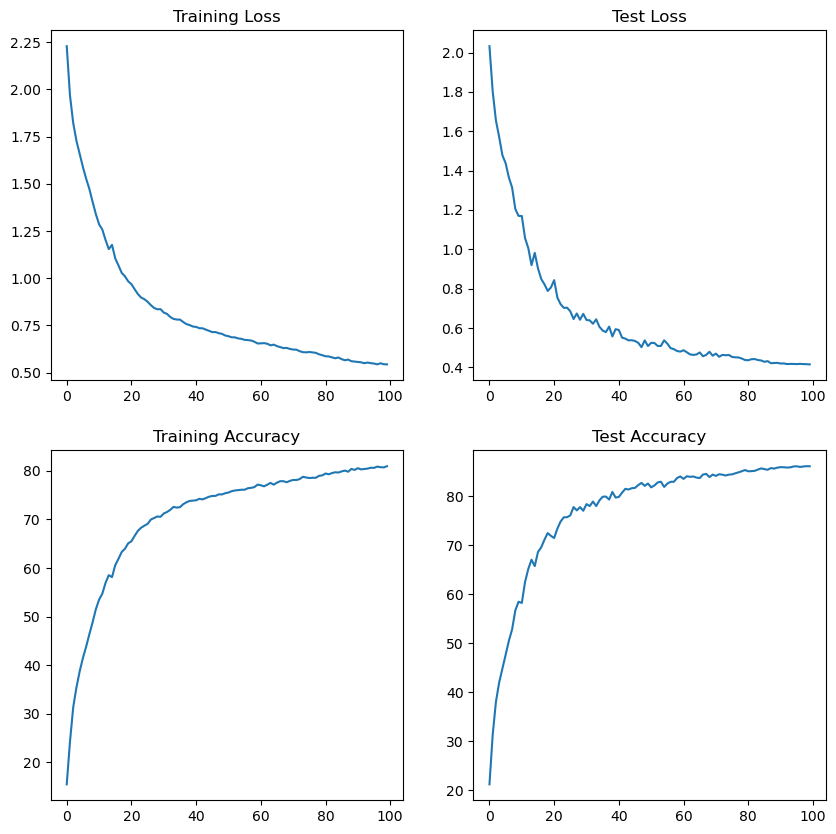

In [15]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04714125..1.0019102].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28160447..1.0019102].


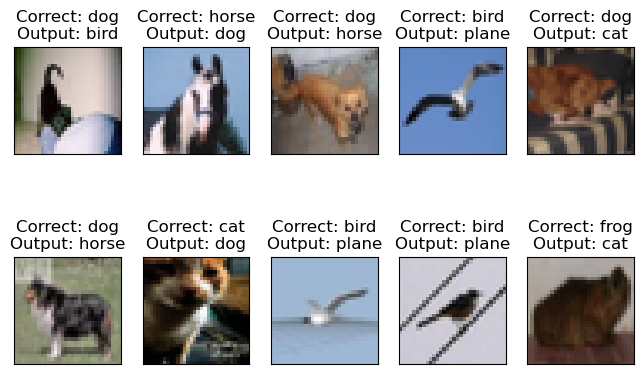

In [16]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=10)